# Breast Cancer synthetic data
## Part 3. Modeling

#### by Grzegorz Furdyn

## Contents

### CRISP-DM Phase 3: Data Preparation
* [Missing values handling](#miss)

### CRISP-DM Phase 4: Modeling

#### Vital status models
* [KNN](#knn)
* [Random Forest](#rf)
* [Gradient Boosting](#gbvit)
* [Logistic Regression](#lr)

#### Dummy vital status models
* [Dummy model - Random Forest](#rfdum)
* [Dummy model - Gradient Boosting](#gbdum)
* [Dummy model - Logistic Regression](#lrdum)

#### 5Y survival models
* [KNN](#knnsurv)
* [Random Forest](#rfsurv)
* [Gradient Boosting](#gbsurv)
* [Logistic Regression](#lrsurv)

## CRISP-DM Phase 3: Data Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.metrics import precision_recall_curve,plot_precision_recall_curve,plot_roc_curve,RocCurveDisplay,PrecisionRecallDisplay
from sklearn import metrics, set_config
import eli5
from eli5.sklearn import PermutationImportance
set_config(display="diagram")
np.random.seed(42)
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [2]:
df = pd.read_csv('Breast_cancer_transformed.csv')

<a id='miss'></a>
### Missing values handling

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58377 entries, 0 to 58376
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   leeft                  58377 non-null  int64  
 1   incjr                  58377 non-null  int64  
 2   vit_stat               58377 non-null  int64  
 3   vit_stat_int           58377 non-null  int64  
 4   tumsoort               58377 non-null  int64  
 5   diag_basis             58377 non-null  int64  
 6   topo_sublok            58377 non-null  object 
 7   later                  57071 non-null  float64
 8   morf                   58377 non-null  int64  
 9   gedrag                 58377 non-null  int64  
 10  diffgrad               49392 non-null  float64
 11  ct                     57506 non-null  object 
 12  cn                     57540 non-null  object 
 13  cm                     55905 non-null  float64
 14  pt                     52809 non-null  object 
 15  pn

Defining subset of features as X

In [4]:
categorical_features = ['tumsoort',
                        'diag_basis',
                        'topo_sublok',
                        'later',
                        'morf',                                  
                        'uitgebr_chir_code',
                        'chemo',
                        'target',
                        'horm',
                        'rt'
                        ]

In [5]:
numeric_features = ['leeft',
                    'incjr',
                    'vit_stat_int',
                    'ond_lymf',
                    'pos_lymf',
                    'tum_afm',
                    'gedrag',
                    'diffgrad',
                    'cm',
                    'pm',
                    'er_stat',
                    'pr_stat',
                    'her2_stat',
                    'dcis_comp',
                    'multifoc',
                    'swk',
                    'swk_uitslag',
                    'mari',
                    'mari_uitslag',
                    'okd',
                    'org_chir',
                    'dir_reconstr',
                    'meta_rt',
                    'meta_chir',
                    'ct_ord',
                    'cn_ord',                         
                    'pt_ord',
                    'pn_ord',
                    'stadium_ord',
                    'cstadium_ord', 
                    'pstadium_ord'
                   ]

In [6]:
df[numeric_features].describe()

,leeft,incjr,vit_stat_int,ond_lymf,pos_lymf,tum_afm,gedrag,diffgrad,cm,pm,...,dir_reconstr,meta_rt,meta_chir,ct_ord,cn_ord,pt_ord,pn_ord,stadium_ord,cstadium_ord,pstadium_ord
count,58377.000000,58377.000000,58377.000000,57172.000000,53158.000000,45312.000000,58377.000000,49392.000000,55905.000000,5208.000000,...,58377.000000,58377.000000,58377.000000,57506.000000,57540.000000,52809.000000,50564.000000,58064.000000,57235.000000,53022.000000
mean,61.855628,2014.733268,1748.631070,4.692174,1.033146,21.789261,2.872792,2.063107,0.053162,0.637289,...,0.137965,0.062233,0.095020,4.725594,0.275182,4.540287,0.897556,2.550772,2.232882,2.255573
std,14.216831,2.908916,1020.057571,9.428165,3.810122,26.434893,0.333208,0.735689,0.224358,0.480829,...,0.344867,0.241581,0.293245,2.102709,0.879610,1.956448,1.720413,2.211826,2.160348,2.085902
min,18.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,53.000000,2012.000000,870.000000,1.000000,0.000000,8.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,0.000000,4.000000,0.000000,1.000000,1.000000,1.000000
50%,62.000000,2015.000000,1646.000000,2.000000,0.000000,15.000000,3.000000,2.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,5.000000,0.000000,5.000000,0.000000,1.000000,1.000000,1.000000
75%,71.000000,2017.000000,2562.000000,4.000000,1.000000,24.000000,3.000000,3.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,6.000000,0.000000,6.000000,1.000000,4.000000,4.000000,4.000000
max,105.000000,2019.000000,4047.000000,97.000000,97.000000,250.000000,3.000000,3.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,11.000000,7.000000,11.000000,9.000000,9.000000,9.000000,9.000000


In [7]:
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

In [8]:
df[categorical_features] = df[categorical_features].fillna('missing')

In [9]:
df.isna().sum()[df.isna().sum() != 0].sort_values(ascending = False)

exp_life                 47080
survival_5Y              23500
years_after_diagnosis    19446
tum_afm_range            15533
pn                        7813
pt                        5568
pstadium                  5355
cstadium                  1142
ct                         871
cn                         837
stadium                    313
stadiumtot                 313
dtype: int64

In [10]:
df[categorical_features] = df[categorical_features].astype('str')

In [11]:
df_fin = df.copy()

## CRISP-DM Phase 4: Modeling

## Vital status models

The modeling has an objective of predicting patient's vital status at time vit_stat_int (days from incidence), based on all available information . We will start by a simple classification model  vit_stat as target value.

<a id='knn'></a>
### KNN

In [12]:
def preprocess1(df):
    dfmod = pd.merge(df[categorical_features], df[numeric_features], left_index=True, right_index=True)
    dfmod = dfmod.join(df['vit_stat'])
    return dfmod

In [13]:
df = df_fin

In [14]:
df = preprocess1(df)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58377 entries, 0 to 58376
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tumsoort           58377 non-null  object 
 1   diag_basis         58377 non-null  object 
 2   topo_sublok        58377 non-null  object 
 3   later              58377 non-null  object 
 4   morf               58377 non-null  object 
 5   uitgebr_chir_code  58377 non-null  object 
 6   chemo              58377 non-null  object 
 7   target             58377 non-null  object 
 8   horm               58377 non-null  object 
 9   rt                 58377 non-null  object 
 10  leeft              58377 non-null  int64  
 11  incjr              58377 non-null  int64  
 12  vit_stat_int       58377 non-null  int64  
 13  ond_lymf           58377 non-null  float64
 14  pos_lymf           58377 non-null  float64
 15  tum_afm            58377 non-null  float64
 16  gedrag             583

In [16]:
df.head()

,tumsoort,diag_basis,topo_sublok,later,morf,uitgebr_chir_code,chemo,target,horm,rt,...,meta_rt,meta_chir,ct_ord,cn_ord,pt_ord,pn_ord,stadium_ord,cstadium_ord,pstadium_ord,vit_stat
0,501300,7,C508,1.0,8500,missing,0.0,4.0,0.0,0.0,...,0.0,0.0,5.0,0.0,5.0,0.0,1.0,1.0,1.0,1
1,503200,2,C505,1.0,8520,131C50,1.0,0.0,2.0,2.0,...,0.0,0.0,5.0,0.0,5.0,0.0,4.0,1.0,1.0,0
2,502200,7,C508,2.0,8500,missing,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,501300,7,C504,1.0,8481,131C50,0.0,0.0,0.0,2.0,...,0.0,0.0,4.0,0.0,5.0,0.0,1.0,1.0,1.0,0
4,501300,7,C504,2.0,8500,131C50,0.0,0.0,2.0,2.0,...,0.0,0.0,5.0,0.0,5.0,1.0,1.0,1.0,3.0,0


In [17]:
X = df.drop('vit_stat', axis = 1)

In [18]:
X = pd.get_dummies(X,drop_first=False)

In [19]:
y = df['vit_stat']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [21]:
scaler = StandardScaler()

In [22]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
model_KNN = KNeighborsClassifier()

In [24]:
model_KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [25]:
y_pred_knn =model_KNN.predict(X_test)

In [26]:
confusion_matrix(y_test,y_pred_knn)

array([[9055,  360],
       [1952,  309]], dtype=int64)

In [27]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89      9415
           1       0.46      0.14      0.21      2261

    accuracy                           0.80     11676
   macro avg       0.64      0.55      0.55     11676
weighted avg       0.75      0.80      0.76     11676



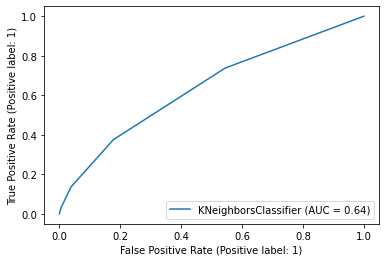

In [28]:
knn_disp = RocCurveDisplay.from_estimator(model_KNN, X_test, y_test)

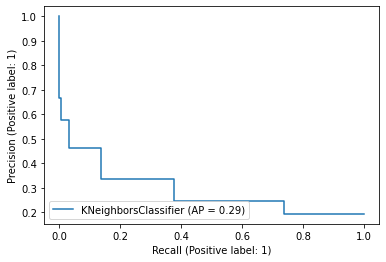

In [29]:
plot_precision_recall_curve(model_KNN, X_test, y_test)

<a id='rf'></a>
### Random Forest

In [30]:
model_RF = RandomForestClassifier()

In [31]:
model_RF.fit(X_train, y_train)

RandomForestClassifier()

In [32]:
y_pred_rf =model_RF.predict(X_test)

In [33]:
confusion_matrix(y_test,y_pred_rf)

array([[9317,   98],
       [ 811, 1450]], dtype=int64)

In [34]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      9415
           1       0.94      0.64      0.76      2261

    accuracy                           0.92     11676
   macro avg       0.93      0.82      0.86     11676
weighted avg       0.92      0.92      0.92     11676



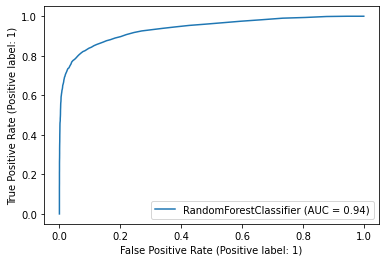

In [35]:
plot_roc_curve(model_RF, X_test, y_test)

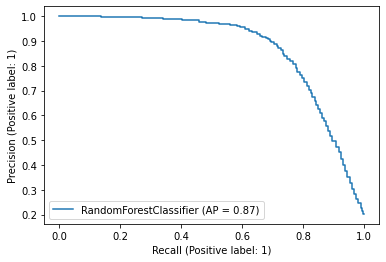

In [36]:
plot_precision_recall_curve(model_RF, X_test, y_test)

<a id='gbvit'></a>
### Gradient Boosting

In [37]:
model_GB = GradientBoostingClassifier()

In [38]:
model_GB.fit(X_train,y_train)

GradientBoostingClassifier()

In [39]:
y_pred_gb =model_GB.predict(X_test)

In [40]:
confusion_matrix(y_test,y_pred_gb)

array([[9284,  131],
       [ 665, 1596]], dtype=int64)

In [41]:
print(classification_report(y_test,y_pred_gb))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9415
           1       0.92      0.71      0.80      2261

    accuracy                           0.93     11676
   macro avg       0.93      0.85      0.88     11676
weighted avg       0.93      0.93      0.93     11676



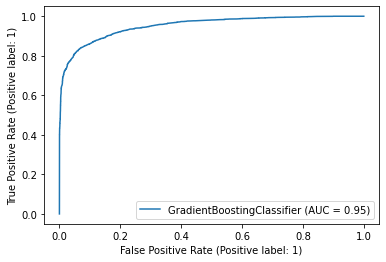

In [42]:
plot_roc_curve(model_GB, X_test, y_test)

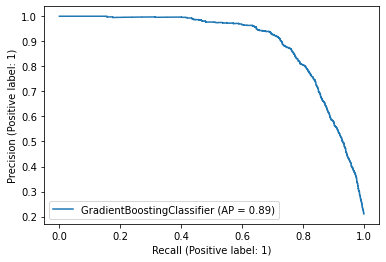

In [43]:
plot_precision_recall_curve(model_GB, X_test, y_test)

<a id='lr'></a>
### Logistic Regression

In [44]:
df = df_fin

In [45]:
def preprocess2(df):
    dfmod = pd.merge(df[categorical_features], df[numeric_features], left_index=True, right_index=True)
    dfmod = dfmod.join(df['vit_stat'])
    return dfmod

In [46]:
df = preprocess2(df)

In [47]:
df.columns

Index(['tumsoort', 'diag_basis', 'topo_sublok', 'later', 'morf',
       'uitgebr_chir_code', 'chemo', 'target', 'horm', 'rt', 'leeft', 'incjr',
       'vit_stat_int', 'ond_lymf', 'pos_lymf', 'tum_afm', 'gedrag', 'diffgrad',
       'cm', 'pm', 'er_stat', 'pr_stat', 'her2_stat', 'dcis_comp', 'multifoc',
       'swk', 'swk_uitslag', 'mari', 'mari_uitslag', 'okd', 'org_chir',
       'dir_reconstr', 'meta_rt', 'meta_chir', 'ct_ord', 'cn_ord', 'pt_ord',
       'pn_ord', 'stadium_ord', 'cstadium_ord', 'pstadium_ord', 'vit_stat'],
      dtype='object')

In [48]:
X = pd.get_dummies(X,drop_first=False)

In [49]:
y = df['vit_stat']

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [51]:
scaler = StandardScaler()

In [52]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
model_LR = LogisticRegressionCV()

In [54]:
model_LR.fit(X_train, y_train)

LogisticRegressionCV()

In [55]:
y_pred_lr = model_LR.predict(X_test)

In [56]:
confusion_matrix(y_test,y_pred_lr)

array([[9204,  211],
       [ 825, 1436]], dtype=int64)

In [57]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      9415
           1       0.87      0.64      0.73      2261

    accuracy                           0.91     11676
   macro avg       0.89      0.81      0.84     11676
weighted avg       0.91      0.91      0.91     11676



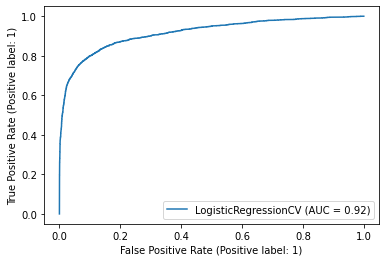

In [58]:
plot_roc_curve(model_LR, X_test, y_test)

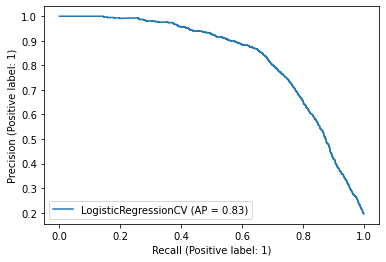

In [59]:
plot_precision_recall_curve(model_LR, X_test, y_test)

In [60]:
model_LR.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [61]:
coefs_LR = pd.DataFrame(data = model_LR.coef_[0], index=X.columns, columns = ['Coef']).sort_values(by = 'Coef')
coefs_LR

,Coef
incjr,-3.239495
vit_stat_int,-3.080809
cn_ord,-0.049752
morf_8509,-0.048825
uitgebr_chir_code_132C50,-0.048725
morf_8541,-0.040651
uitgebr_chir_code_missing,-0.039210
morf_8211,-0.037291
topo_sublok_C501,-0.031964
tumsoort_503200,-0.026949


In [62]:
coefs_LR = pd.concat([coefs_LR.head(10), coefs_LR.tail(10)], axis = 0)

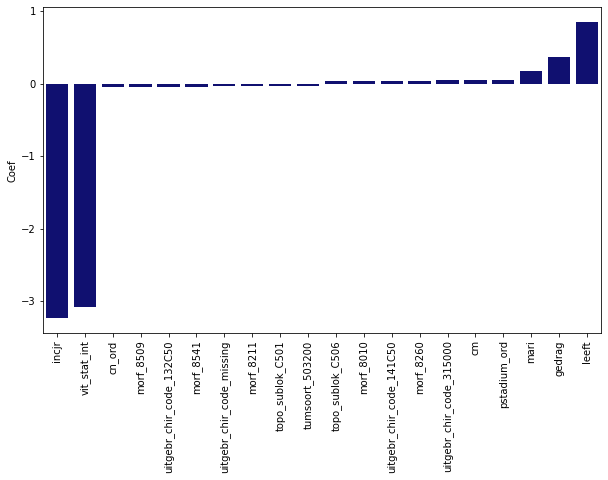

In [63]:
plt.figure(figsize=(10,6))
sns.barplot(data = coefs_LR, x = coefs_LR.index, y = 'Coef', color = 'navy' )
plt.xticks(rotation = 90)
plt.show()

One can clearly see that the overwhelming part of the model's "predictive ability" comes in fact from the features not related to the cancer - the year of incidence, time passed since the incidence, and patient's age. This kind of model seems to take into account any cancer diagnostic characteristics in its predictions in only very small degree.
To investigate this deeper, let us construct dummy models that use only these three features, and compare the quality of predictions with models incorporating all the features.

## Dummy vital status models

<a id='rfdum'></a>
### Dummy model - Random Forest

In [64]:
df = df_fin[['vit_stat','leeft', 'incjr', 'vit_stat_int']]

In [65]:
df.isna().sum()

vit_stat        0
leeft           0
incjr           0
vit_stat_int    0
dtype: int64

In [66]:
df.head()

,vit_stat,leeft,incjr,vit_stat_int
0,1,93,2013,390
1,0,60,2010,3592
2,0,43,2010,4011
3,0,38,2012,2811
4,0,29,2019,724


In [67]:
X = df.drop('vit_stat', axis = 1)

In [68]:
y = df['vit_stat']

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [70]:
model_RF_dum = RandomForestClassifier()

In [71]:
model_RF_dum.fit(X_train, y_train)

RandomForestClassifier()

In [72]:
y_pred_rf_dum =model_RF_dum.predict(X_test)

In [73]:
confusion_matrix(y_test,y_pred_rf_dum)

array([[9019,  396],
       [ 595, 1666]], dtype=int64)

In [74]:
print(classification_report(y_test,y_pred_rf_dum))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      9415
           1       0.81      0.74      0.77      2261

    accuracy                           0.92     11676
   macro avg       0.87      0.85      0.86     11676
weighted avg       0.91      0.92      0.91     11676



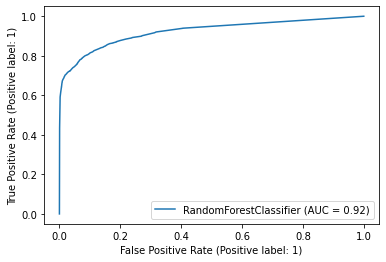

In [75]:
plot_roc_curve(model_RF_dum, X_test, y_test)

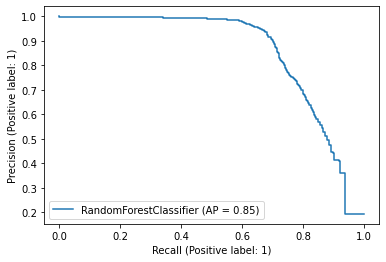

In [76]:
plot_precision_recall_curve(model_RF_dum, X_test, y_test)

In [77]:
perm = PermutationImportance(model_RF_dum, random_state=RANDOM_STATE).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.3253 ± 0.0086,incjr
0.3056 ± 0.0038,vit_stat_int
0.0234 ± 0.0036,leeft


<a id='gbdum'></a>
### Dummy model - Gradient Boosting

In [78]:
model_GB_dum = GradientBoostingClassifier()

In [79]:
model_GB_dum.fit(X_train,y_train)

GradientBoostingClassifier()

In [80]:
y_pred_gb_dum = model_GB_dum.predict(X_test)

In [81]:
confusion_matrix(y_test,y_pred_gb_dum)

array([[9299,  116],
       [ 644, 1617]], dtype=int64)

In [82]:
print(classification_report(y_test,y_pred_gb_dum))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      9415
           1       0.93      0.72      0.81      2261

    accuracy                           0.93     11676
   macro avg       0.93      0.85      0.89     11676
weighted avg       0.93      0.93      0.93     11676



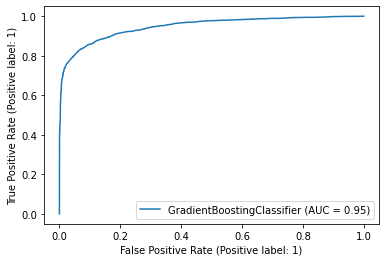

In [83]:
plot_roc_curve(model_GB_dum, X_test, y_test)

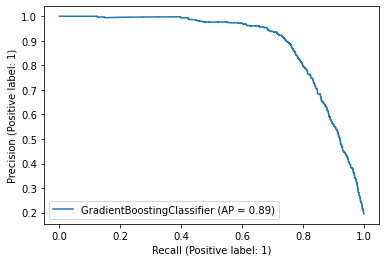

In [84]:
plot_precision_recall_curve(model_GB_dum, X_test, y_test)

<a id='lrdum'></a>
### Dummy model - Logistic Regression

In [85]:
X = pd.get_dummies(X,drop_first=False)

In [86]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [87]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [88]:
model_LR_dum = LogisticRegressionCV()

In [89]:
model_LR_dum.fit(X_train, y_train)

LogisticRegressionCV()

In [90]:
y_pred_lr_dum = model_LR_dum.predict(X_test)

In [91]:
confusion_matrix(y_test,y_pred_lr_dum)

array([[9204,  211],
       [ 840, 1421]], dtype=int64)

In [92]:
print(classification_report(y_test,y_pred_lr_dum))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      9415
           1       0.87      0.63      0.73      2261

    accuracy                           0.91     11676
   macro avg       0.89      0.80      0.84     11676
weighted avg       0.91      0.91      0.90     11676



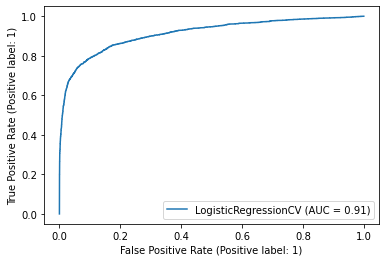

In [93]:
plot_roc_curve(model_LR_dum, X_test, y_test)

In [94]:
coefs_LR_dum = pd.DataFrame(data = model_LR_dum.coef_[0], index=X.columns, columns = ['Coef']).sort_values(by = 'Coef')
coefs_LR_dum

,Coef
incjr,-3.219996
vit_stat_int,-3.094260
leeft,0.866559


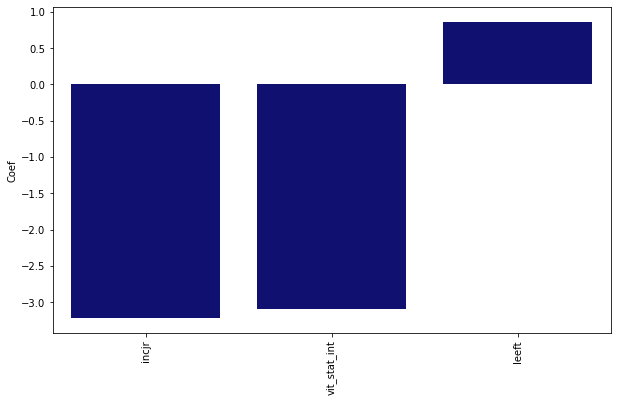

In [95]:
plt.figure(figsize=(10,6))
sns.barplot(data = coefs_LR_dum, x = coefs_LR_dum.index, y = 'Coef', color = 'navy' )
plt.xticks(rotation = 90)
plt.show()

Conclusion: the model constructed in this way can only answer predict likelihood of a patient being dead or alive, given the year of cancer incidence, his age at that time and time passed since. It does not answer a more relevant question, namely what is the chance of patient's 5 year survival, given the information one has just after cancer detection and the initial treatment, namely characteristics of patient, cancer and treatment applied. 

To answer this, let us construct a model with the 5 year survival as target variable.

## 5Y Survival models

In [96]:
df = pd.read_csv('Breast_cancer_transformed_sr.csv')

In [97]:
df = df.drop('vit_stat_int', axis = 1)

In [98]:
numeric_features.remove('vit_stat_int')

In [99]:
#df.info()

In [100]:
df = df.drop(df.loc[df['survival_5Y'].isnull()].index)

In [101]:
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

In [102]:
df[categorical_features] = df[categorical_features].fillna('missing')

In [103]:
df[categorical_features] = df[categorical_features].astype('str')

In [104]:
df_fin = df.copy()

<a id='knnsurv'></a>
### KNN

In [105]:
def preprocess(df):
    df_mod = pd.merge(df[categorical_features], df[numeric_features], left_index=True, right_index=True)
    df_mod = df_mod.join(df['survival_5Y'])
    return df_mod

In [106]:
df = preprocess(df)

In [107]:
X = df.drop('survival_5Y', axis = 1)

In [108]:
X = pd.get_dummies(X,drop_first=False)

In [109]:
y = df['survival_5Y']

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [111]:
scaler = StandardScaler()

In [112]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [113]:
model_KNN = KNeighborsClassifier()

In [114]:
model_KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [115]:
y_pred_knn =model_KNN.predict(X_test)

In [116]:
confusion_matrix(y_test,y_pred_knn)

array([[  82, 1006],
       [ 154, 5154]], dtype=int64)

In [117]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.35      0.08      0.12      1088
         1.0       0.84      0.97      0.90      5308

    accuracy                           0.82      6396
   macro avg       0.59      0.52      0.51      6396
weighted avg       0.75      0.82      0.77      6396



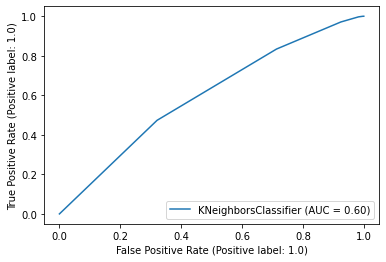

In [118]:
knn_disp = RocCurveDisplay.from_estimator(model_KNN, X_test, y_test)

<a id='rfsurv'></a>
### Random Forest

In [119]:
model_RF = RandomForestClassifier()

In [120]:
model_RF.fit(X_train, y_train)

RandomForestClassifier()

In [121]:
y_pred_rf = model_RF.predict(X_test)

In [122]:
confusion_matrix(y_test, y_pred_rf)

array([[ 226,  862],
       [ 194, 5114]], dtype=int64)

In [123]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.54      0.21      0.30      1088
         1.0       0.86      0.96      0.91      5308

    accuracy                           0.83      6396
   macro avg       0.70      0.59      0.60      6396
weighted avg       0.80      0.83      0.80      6396



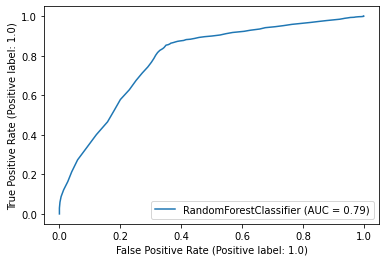

In [124]:
rf_disp = RocCurveDisplay.from_estimator(model_RF, X_test, y_test)

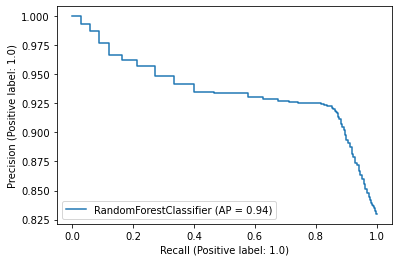

In [125]:
plot_precision_recall_curve(model_RF, X_test, y_test)

<a id='gbsurv'></a>
### Gradient Boosting

In [126]:
model_GB_surv = GradientBoostingClassifier()

In [127]:
model_GB_surv.fit(X_train,y_train)

GradientBoostingClassifier()

In [128]:
y_pred_gb_surv = model_GB_surv.predict(X_test)

In [129]:
confusion_matrix(y_test, y_pred_gb_surv)

array([[ 282,  806],
       [ 249, 5059]], dtype=int64)

In [130]:
print(classification_report(y_test,y_pred_gb_surv))

              precision    recall  f1-score   support

         0.0       0.53      0.26      0.35      1088
         1.0       0.86      0.95      0.91      5308

    accuracy                           0.84      6396
   macro avg       0.70      0.61      0.63      6396
weighted avg       0.81      0.84      0.81      6396



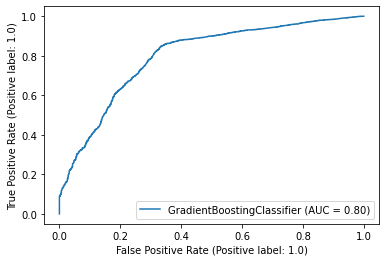

In [131]:
gb_disp = RocCurveDisplay.from_estimator(model_GB_surv, X_test, y_test)

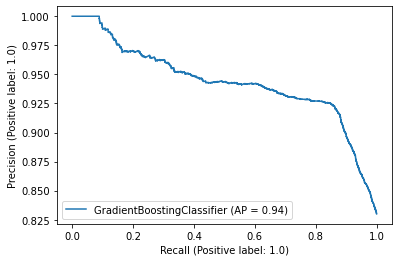

In [132]:
plot_precision_recall_curve(model_GB_surv, X_test, y_test)

<a id='lrsurv'></a>
### Logistic regression

In [133]:
df = df_fin

In [134]:
def preprocess2(df):
    dfmod = pd.merge(df[categorical_features], df[numeric_features], left_index=True, right_index=True)
    dfmod = dfmod.join(df['survival_5Y'])
    return dfmod

In [135]:
df = preprocess2(df)

In [136]:
df.columns

Index(['tumsoort', 'diag_basis', 'topo_sublok', 'later', 'morf',
       'uitgebr_chir_code', 'chemo', 'target', 'horm', 'rt', 'leeft', 'incjr',
       'ond_lymf', 'pos_lymf', 'tum_afm', 'gedrag', 'diffgrad', 'cm', 'pm',
       'er_stat', 'pr_stat', 'her2_stat', 'dcis_comp', 'multifoc', 'swk',
       'swk_uitslag', 'mari', 'mari_uitslag', 'okd', 'org_chir',
       'dir_reconstr', 'meta_rt', 'meta_chir', 'ct_ord', 'cn_ord', 'pt_ord',
       'pn_ord', 'stadium_ord', 'cstadium_ord', 'pstadium_ord', 'survival_5Y'],
      dtype='object')

In [137]:
X = pd.get_dummies(X,drop_first=False)

In [138]:
y = df['survival_5Y']

In [139]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [140]:
scaler = StandardScaler()

In [141]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [142]:
model_LR_surv = LogisticRegressionCV()

In [143]:
model_LR_surv.fit(X_train,y_train)

LogisticRegressionCV()

In [144]:
y_pred_lr_surv = model_LR_surv.predict(X_test)

In [145]:
confusion_matrix(y_test, y_pred_lr_surv)

array([[  42, 1046],
       [  27, 5281]], dtype=int64)

In [146]:
print(classification_report(y_test,y_pred_lr_surv))

              precision    recall  f1-score   support

         0.0       0.61      0.04      0.07      1088
         1.0       0.83      0.99      0.91      5308

    accuracy                           0.83      6396
   macro avg       0.72      0.52      0.49      6396
weighted avg       0.80      0.83      0.77      6396



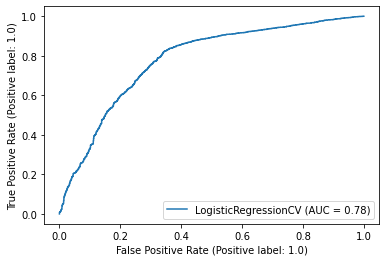

In [147]:
lr_disp = RocCurveDisplay.from_estimator(model_LR_surv, X_test, y_test)

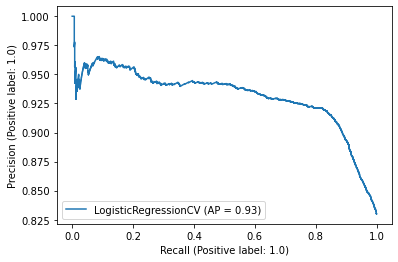

In [148]:
plot_precision_recall_curve(model_LR_surv, X_test, y_test)

In [149]:
model_LR_surv.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [150]:
coefs_LR_surv = pd.DataFrame(data = model_LR_surv.coef_[0], index=X.columns, columns = ['Coef']).sort_values(by = 'Coef')
coefs_LR_surv

,Coef
leeft,-0.677862
mari,-0.169195
gedrag,-0.150028
tumsoort_501300,-0.066439
horm_4.0,-0.023370
morf_8010,-0.021640
ct_ord,-0.021352
morf_8401,-0.019275
later_missing,-0.016645
morf_8201,-0.015993


In [151]:
coefs_LR_surv = pd.concat([coefs_LR_surv.head(10), coefs_LR_surv.tail(10)], axis = 0)

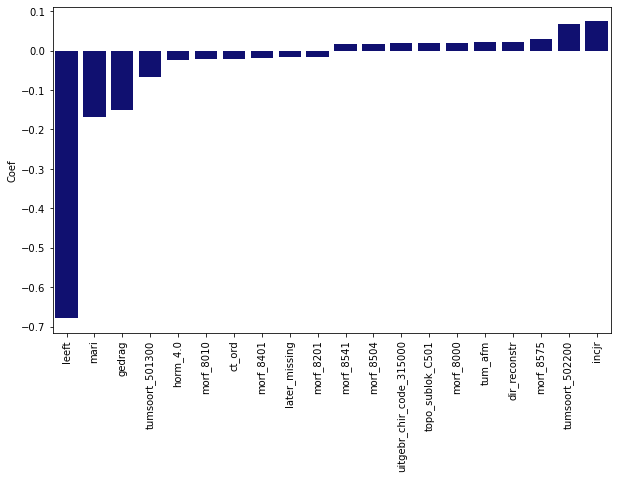

In [152]:
plt.figure(figsize=(10,6))
sns.barplot(data = coefs_LR_surv, x = coefs_LR_surv.index, y = 'Coef', color = 'navy' )
plt.xticks(rotation = 90)
plt.show()